# 1 .- Camera Calibration and Undistortion

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os.path as path
import pickle

def cameraCalibration(dir_imgs):
    
    # Internal corners on x and y of the images used for calibration.
    nx = 9
    ny = 6
    
    objpoints = [] # 3D Points in the real world space (x,y,z) z= 0 since board is in a flat surface. 
    imgpoints = [] # 2D Points in image plane (these need to be found and saved)

    #Prepare the object points, x and y are the corners of the image in this case x = 9 and y = 6
    objp = np.zeros((nx*ny,3), np.float32)

    # mgrid returns the coordinates values for a grid size and re-shape it into 2 columns, x and y. Z remains the same.
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # List of calibration images names taken from the dir_imgs
    #images = glob.glob(path.join(dir_imgs, 'calibration*.jpg'))
    images = glob.glob(path.join(dir_imgs, 'calibration*.jpg'))
    
    for imgName in images:
        #Read each image
        img = cv2.imread(imgName)
        
        #Convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        #Find corners and save the result
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # IF corners found, add imagepoints and objpoints
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    
        # Draw and display the corners in the image.
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)

    # Calibrate the camera using objpoints and imgpoints
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    (objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

def undistorImage(img, mtx, dist):
    
    # Undistord the image using the matrix returned at Camera Calibration step
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
    
################################################### DRIVER CODE ############################################################
#Read Image
img = cv2.imread('test_images/test1.jpg')
img2 = cv2.imread('camera_cal/calibration1.jpg')

#Run Calibration
ret, mtx, dist, rvecs, tvecs = cameraCalibration(dir_imgs='camera_cal')

#Undistorted image using the coeficients from the previous calibration
img_undistorted = undistorImage(img, mtx, dist)
img_undistorted2 = undistorImage(img2, mtx, dist)

#Write Image out
cv2.imwrite('output_images/calibration_test_1_distorted.jpg', img)
cv2.imwrite('output_images/calibration_test_1_undistorted.jpg', img_undistorted)

cv2.imwrite('output_images/calibration1_distorted.jpg', img2)
cv2.imwrite('output_images/calibration1_undistorted.jpg', img_undistorted2)

################################################### PLOT ######################################################################
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# 2.- Color transformations and Gradients 

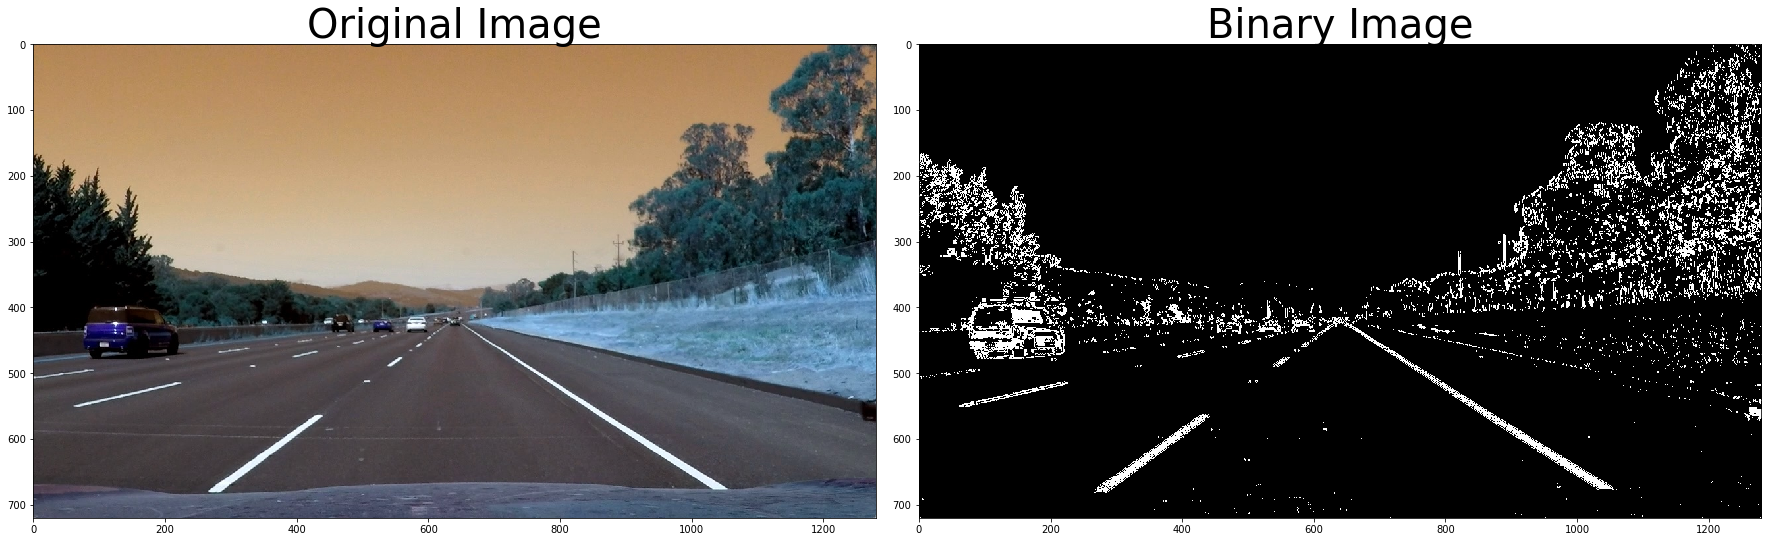

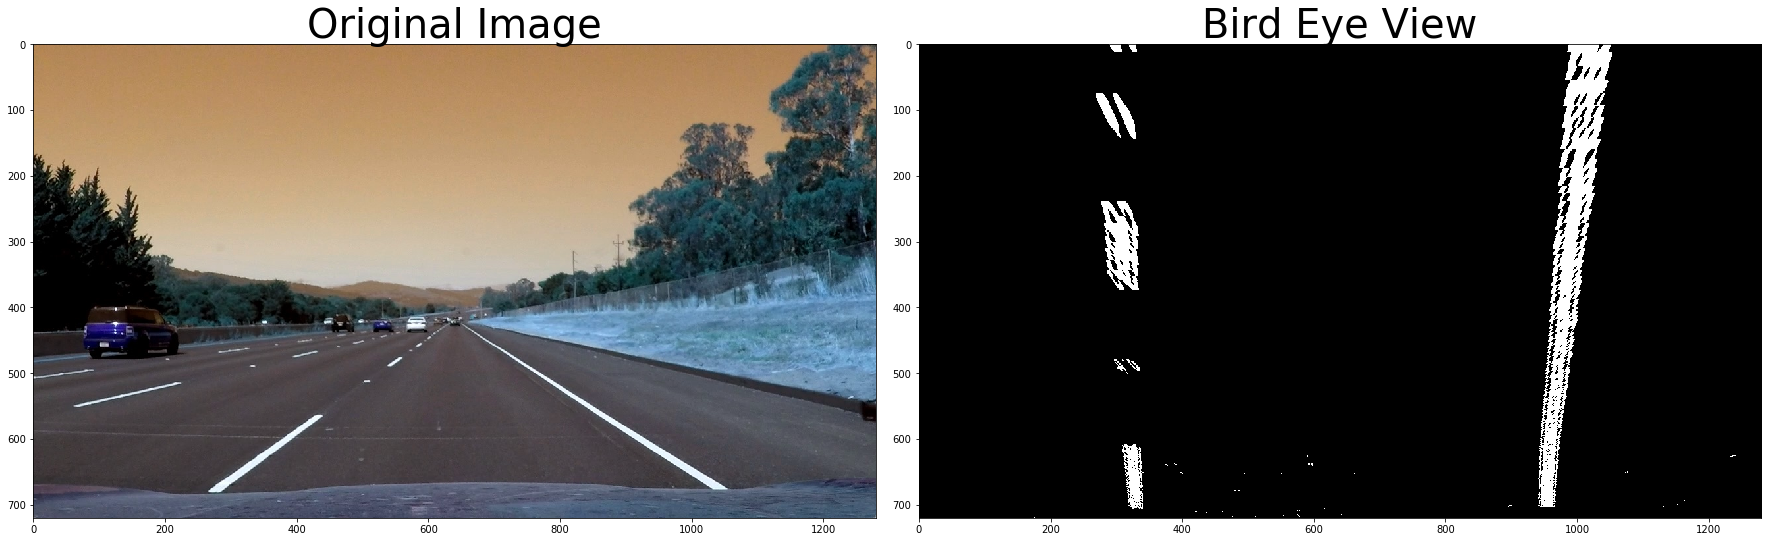

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

# Color and Gradient combined
def colorAndGradient(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    #convert image to gray to use it in the Gradient
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    #plt.imshow(sxbinary, cmap='gray')
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

def birdEyeView(img):
    
    offset = 100 # offset for dst points
    img_size = (img.shape[1], img.shape[0])

    # Select 4 points  
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Inverse Matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, Minv

##########################################################  DRIVER CODE ######################################################

# Read in an image
image = cv2.imread('test_images\straight_lines2.jpg')
#plt.imshow(image)

binary_warped = colorAndGradient(image)

bin_warped_out = np.dstack((binary_warped, binary_warped, binary_warped))*255

birdEye, Minv = birdEyeView(binary_warped)

birdEye_out = np.dstack((birdEye, birdEye, birdEye))*255

#Save images
cv2.imwrite('output_images/straightLines2_Binary_Warped.jpg', bin_warped_out)
cv2.imwrite('output_images/straightLines2_BirdEye.jpg', birdEye_out)

################################################################ PLOTS #######################################################
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f, (ax3, ax4) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax3.imshow(image)
ax3.set_title('Original Image', fontsize=40)
ax4.imshow(birdEye, cmap='gray')
ax4.set_title('Bird Eye View', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# 3.- Find Lanes and Line Class

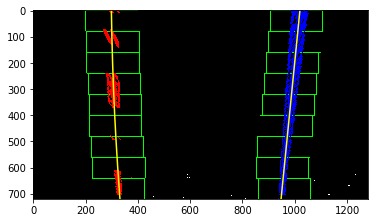

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

#################################################  LINE CLASS START ###########################################################

class Line:
    
    def __init__(self):
        # Coordinates of the pixels of the line detected
        self.pixels_x = None
        self.pixels_y = None
        
        # Flag to know if the lanes was previously detected
        self.previous_detected = False
        
        # Coefficientes for the fitted polynomial in pixels and meters of the previous iteration
        self.previous_pixel_fit = None
        self.previous_meter_fit = None
        
        # Curvature's radius
        self.curvature_radius = None
    
    #Update the parameters with the new coeficients of the new itereation
    def updateLine(self, detectionState, new_pixel_fit, new_meter_fit):
        
        self.previous_detected = detectionState
        self.previous_pixel_fit = new_pixel_fit
        self.previous_meter_fit = new_meter_fit

          
#################################################  LINE CLASS FINISH ##########################################################        

def find_lane_pixels(birdEye_binary_img, leftLine, rightLine):
    
    histogram = np.sum(birdEye_binary_img[birdEye_binary_img.shape[0]//2:,:], axis=0)
    out_img = np.dstack((birdEye_binary_img, birdEye_binary_img, birdEye_binary_img))*255
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Number of sliding windows
    nwindows = 9
    # Width of the windows +/- margin
    margin = 100
    # Minimum number of pixels found to recenter window
    minpix = 50
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720   # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(birdEye_binary_img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = birdEye_binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = birdEye_binary_img.shape[0] - (window+1)*window_height
        win_y_high = birdEye_binary_img.shape[0] - window*window_height
        # Boundaries of the window 
        win_xleft_low = leftx_current - margin # Update this
        win_xleft_high = leftx_current + margin # Update this
        win_xright_low = rightx_current - margin # Update this
        win_xright_high = rightx_current + margin # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftLine.pixels_x = nonzerox[left_lane_inds]
    leftLine.pixels_y = nonzeroy[left_lane_inds] 
    rightLine.pixels_x = nonzerox[right_lane_inds]
    rightLine.pixels_y = nonzeroy[right_lane_inds]
    
    # If This function is run, then previous_detected is true
    previous_detected = True
    
    # Polynomial Fit 
    if not list(leftLine.pixels_x) or not list(leftLine.pixels_y):
        previous_detected = False
        new_left_pixel_fit = leftLine.previous_pixel_fit
        new_left_meter_fit = leftLine.previous_meter_fit
    else:
        new_left_pixel_fit = np.polyfit(leftLine.pixels_y, leftLine.pixels_x, 2)
        new_left_meter_fit = np.polyfit(leftLine.pixels_y * ym_per_pix, leftLine.pixels_x * xm_per_pix, 2)

    if not list(rightLine.pixels_x) or not list(rightLine.pixels_y):
        previous_detected = False
        new_right_pixel_fit = rightLine.previous_pixel_fit
        new_right_meter_fit = rightLine.previous_meter_fit
    else:
        new_right_pixel_fit = np.polyfit(rightLine.pixels_y, rightLine.pixels_x, 2)
        new_right_meter_fit = np.polyfit(rightLine.pixels_y * ym_per_pix, rightLine.pixels_x * xm_per_pix, 2)

    # Update the members of the class with the new values of the Line
    
    rightLine.updateLine(previous_detected, new_right_pixel_fit, new_right_meter_fit)
    leftLine.updateLine(previous_detected, new_left_pixel_fit, new_left_meter_fit)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, birdEye_binary_img.shape[0]-1, birdEye_binary_img.shape[0] )
    try:
        left_fitx = new_left_pixel_fit[0]*ploty**2 + new_left_pixel_fit[1]*ploty + new_left_pixel_fit[2]
        right_fitx = new_right_pixel_fit[0]*ploty**2 + new_right_pixel_fit[1]*ploty + new_right_pixel_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return leftLine, rightLine, out_img

def find_lanes_using_previous(birdEye_binary_img, leftLine, rightLine):
    
    # Get coeficients of previous iteration
    left_pixel_fit = leftLine.previous_pixel_fit
    right_pixel_fir = rightLine.previous_pixel_fit
    
    margin = 100
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720   # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Grab activated pixels
    nonzero = birdEye_binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set area of search
    left_lane_inds = ((nonzerox > (left_pixel_fit[0]*(nonzeroy**2) + left_pixel_fit[1]*nonzeroy + 
                    left_pixel_fit[2] - margin)) & (nonzerox < (left_pixel_fit[0]*(nonzeroy**2) + 
                    left_pixel_fit[1]*nonzeroy + left_pixel_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_pixel_fir[0]*(nonzeroy**2) + right_pixel_fir[1]*nonzeroy + 
                    right_pixel_fir[2] - margin)) & (nonzerox < (right_pixel_fir[0]*(nonzeroy**2) + 
                    right_pixel_fir[1]*nonzeroy + right_pixel_fir[2] + margin)))
    
    # Extract Left and Right pixels positions
    leftLine.pixels_x = nonzerox[left_lane_inds]
    leftLine.pixels_y = nonzeroy[left_lane_inds] 
    rightLine.pixels_x = nonzerox[right_lane_inds]
    rightLine.pixels_y = nonzeroy[right_lane_inds]
    
    # Set flag
    previous_detected = True
    
    # Polynomial Fit 
    if not list(leftLine.pixels_x) or not list(leftLine.pixels_y):
        previous_detected = False
        new_left_pixel_fit = leftLine.previous_pixel_fit
        new_left_meter_fit = leftLine.previous_meter_fit
    else:
        new_left_pixel_fit = np.polyfit(leftLine.pixels_y, leftLine.pixels_x, 2)
        new_left_meter_fit = np.polyfit(leftLine.pixels_y * ym_per_pix, leftLine.pixels_x * xm_per_pix, 2)

    if not list(rightLine.pixels_x) or not list(rightLine.pixels_y):
        previous_detected = False
        new_right_pixel_fit = rightLine.previous_pixel_fit
        new_right_meter_fit = rightLine.previous_meter_fit
    else:
        new_right_pixel_fit = np.polyfit(rightLine.pixels_y, rightLine.pixels_x, 2)
        new_right_meter_fit = np.polyfit(rightLine.pixels_y * ym_per_pix, rightLine.pixels_x * xm_per_pix, 2)

    # Update the members of the class with the new values of the Line
    rightLine.updateLine(previous_detected, new_right_pixel_fit, new_right_meter_fit)
    leftLine.updateLine(previous_detected, new_left_pixel_fit, new_left_meter_fit)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, birdEye_binary_img.shape[0]-1, birdEye_binary_img.shape[0] )
    try:
        left_fitx = new_left_pixel_fit[0]*ploty**2 + new_left_pixel_fit[1]*ploty + new_left_pixel_fit[2]
        right_fitx = new_right_pixel_fit[0]*ploty**2 + new_right_pixel_fit[1]*ploty + new_right_pixel_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    return leftLine, rightLine, out_img
    

#########################################################  DRIVE CODE #######################################################

ret, mtx, dist, rvecs, tvecs = cameraCalibration(dir_imgs = 'camera_cal')

left_line = Line()
right_line = Line()
  
img = cv2.imread('test_images\straight_lines2.jpg')
    
img_undistorted = undistorImage(img ,mtx, dist)
    
img_gradient = colorAndGradient(img_undistorted)

img_birdEye, Minv = birdEyeView(img_gradient)

left_line, rightLine, out_img = find_lane_pixels(birdEye, left_line, right_line)

cv2.imwrite('output_images/FinLanes_OutPut.jpg', out_img)
plt.imshow(out_img)




# Complete Process on a Video

Moviepy - Building video output_videos/project_video_output.mp4.
Moviepy - Writing video output_videos/project_video_output.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video_output.mp4
Wall time: 1min 51s


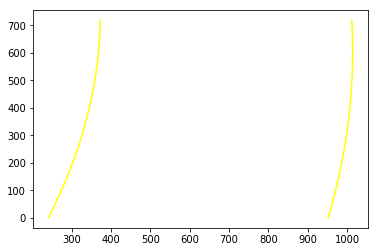

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_line = Line()
right_line = Line()
processed_img = 0


def Plot_Image_Road(undistorted_img, left_line, right_line, Minv):
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, undistorted_img.shape[0]-1, undistorted_img.shape[0])
    
    left_fit = left_line.previous_pixel_fit
    right_fit = right_line.previous_pixel_fit

    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(undistorted_img, dtype=np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(warp_zero, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    dewarped = cv2.warpPerspective(warp_zero, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
       
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, dewarped, 0.3, 0)
    
    return result
    

def Offset_from_Center(left_line, right_line, img_width):
    
    # the return value, offset, is expresed in meters.
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    
    if (left_line.previous_detected) and (right_line.previous_detected):
        #middle point in the image
        image_mid = img_width/2
        
        #Get points of each bottom corner of the lane
        left_line_corner = np.mean(left_line.pixels_x[left_line.pixels_y > 0.95 * left_line.pixels_x.max()])
        right_line_corner = np.mean(right_line.pixels_x[right_line.pixels_y > 0.95 * right_line.pixels_y.max()])
        
        # Calculate the Lane width
        lane_width = right_line_corner - left_line_corner
        
        offset_pixels = abs((left_line_corner +  lane_width / 2) - image_mid)
        
        #Calculate Offset in meters
        offset = xm_per_pix * offset_pixels
                             
    else:
        offset = -1 
        
    return offset

def curvature_radius(left_line, right_line, img):
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, (img.shape[0]-1), img.shape[0])
    
    y_eval = np.max(ploty)

    left_fit_cr = np.polyfit(left_line.pixels_y*ym_per_pix, left_line.pixels_x*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_line.pixels_y*ym_per_pix, right_line.pixels_x*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #print(left_curverad)
    #print(right_curverad)

    curvature = np.mean([left_curverad,right_curverad])
 
    return curvature
    

def Process_Find_Lane(img):
    
    img_undistorted = undistorImage(img ,mtx, dist)
    
    img_gradient = colorAndGradient(img_undistorted)

    img_birdEye, Minv = birdEyeView(img_gradient)
    
    
    global left_line, right_line, processed_img
    
    # If there is a previous detected Line, previous data stored is used, otherwise run first time
    if (processed_img > 0) and (left_line.previous_detected) and (right_line.previous_detected) :
        left_line, right_Line, img_lane = find_lanes_using_previous(img_birdEye, left_line, right_line)
    else:
        left_line, right_Line, img_lane = find_lane_pixels(img_birdEye, left_line, right_line)
                             
    processed_img = processed_img + 1
    
    # Pass the width of the image to calculate the offset
    offset = Offset_from_Center(left_line, right_Line, img.shape[1])
    # Pass the left and right lines to calculate the curvature radius
    mean_curvature_radius = curvature_radius(left_line, right_Line, img)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    img_road = Plot_Image_Road(img_undistorted, left_line, right_line, Minv)
    
    cv2.putText(img_road, 'Radius of Curvature: {:.02f} m'.format(mean_curvature_radius), (50, 60), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(img_road, 'Offset from center: {:.02f} m'.format(offset), (50, 100), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
                         
    return img_road


def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = Process_Find_Lane(image)

    return result

###################################################### DRIVER CODE ##########################################################

images_selec = False

if images_selec:
    test_img_dir = 'test_images'
    for test_img in os.listdir(test_img_dir):
        frame = cv2.imread(os.path.join(test_img_dir, test_img))

        final_img = Process_Find_Lane(frame)

        cv2.imwrite('output_images/{}'.format(test_img), final_img)

        plt.imshow(cv2.cvtColor(final_img, code=cv2.COLOR_BGR2RGB))
        plt.show()
else:
    white_output = 'output_videos/project_video_output.mp4'
    #clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
    clip1 = VideoFileClip("project_video.mp4")
    #clip1 = VideoFileClip("challenge_video.mp4")
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)
    